Prueba desempeño
Parámetros de la prueba:

Arquitectura: InceptionV3

Datos:skin-cancer-malignant-vs-benign


Data Augmentation: Yes

Horizontal flip : true

Vertical flip : true

K-Fold Validation: No

Hyperparameter Tuning: No

Parámetros estáticos de entrenamiento:


lr = 1e-3

init = 'normal'

activ = 'relu'

activ_last = 'softmax'

optim = 'adam'

epochs = 20

batch_size = 64

Notas:


Se reemplazo la capa flatten por GlobalAveragePooling debido a que generaba problemas en el entrenamiento.En particular elevaba considerablemente el valor de las perdidas y al ser reemplazada el modelo tuvo convergencia. Se recomienda investigar que efectos tiene GlobalAveragePooling sobre la red.

Se implemento la funcion para el Test

Se implemento F1 Score

Se implemento la matriz de confusion (normalizada)


In [ ]:
# Librerias Basicas 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
import seaborn as sns
import itertools
from glob import glob
from PIL import Image
import PIL.Image
from IPython.display import Image
np.random.seed(11) # It's my lucky number

# Librerias de preprocesamiento y metricas
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score

# Librerias para backend, arquitectura y entrenamiento
import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.layers.core import Activation
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.applications import imagenet_utils
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

**Instalar los repositorios de kaggle para descargar los datos.**

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
api_token = {"username":"dianamerchanuis","key":"2218e75dd31a7dba96e741fd50c2a026"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign --force

!mkdir Mob_v1_BM

 96% 311M/325M [00:01<00:00, 232MB/s]
100% 325M/325M [00:01<00:00, 187MB/s]


Desempaquetar los datos descargados

In [ ]:
! unzip skin-cancer-malignant-vs-benign.zip 

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: data/train/benign/420.jpg  
  inflating: data/train/benign/421.jpg  
  inflating: data/train/benign/422.jpg  
  inflating: data/train/benign/423.jpg  
  inflating: data/train/benign/424.jpg  
  inflating: data/train/benign/425.jpg  
  inflating: data/train/benign/426.jpg  
  inflating: data/train/benign/429.jpg  
  inflating: data/train/benign/43.jpg  
  inflating: data/train/benign/430.jpg  
  inflating: data/train/benign/431.jpg  
  inflating: data/train/benign/432.jpg  
  inflating: data/train/benign/434.jpg  
  inflating: data/train/benign/435.jpg  
  inflating: data/train/benign/438.jpg  
  inflating: data/train/benign/439.jpg  
  inflating: data/train/benign/440.jpg  
  inflating: data/train/benign/441.jpg  
  inflating: data/train/benign/442.jpg  
  inflating: data/train/benign/443.jpg  
  inflating: data/train/benign/445.jpg  
  inflating: data/train/benign/446.jpg  
  inflating: data/train/benign/4

Preprocesar y organizar los datos

In [ ]:
# identificar las rutas y los nombres de las carpetas
folder_benign_train = '../content/data/train/benign'
folder_malignant_train = '../content/data/train/malignant'

folder_benign_test = '../content/data/test/benign'
folder_malignant_test = '../content/data/test/malignant'

read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

# cargar las imagenes de train 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Cargar las imagenes de test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Crear etiquetas
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

# Crear datos combinados para train y test 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Randomizar los datos
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


Graficar algunos datos para prueba (celda para opcional)

In [ ]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [ ]:

# Etiquetas a categoricas 
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

# Normalización 
X_train = X_train/255.
X_test = X_test/255.

**Crear modelo INCEPTIONV3**

In [ ]:
base_model=InceptionV3(input_shape = (224,224,3), weights='imagenet',include_top=False) # importar mobilenet y descartar la ultima capa

x=base_model.output
#x = Flatten()(x)
x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) 
#x=Dense(1024,activation='relu')(x) 
x=Dense(1024,activation='relu')(x) 
x = Dropout(0.25)(x)
preds=Dense(2,activation='softmax')(x) 

model=Model(inputs=base_model.input,outputs=preds)
Model.summary(model)

87916544/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
input_shape = (224,224,3)
lr = 1e-4
init = 'normal'
activ = 'relu'
optim = keras.optimizers.Adam(learning_rate=lr)
epochs = 100
batch_size = 64
img_height= 224
img_width = 224

train_data_dir='../content/data/train'
test_data_dir='../content/data/test'

train_datagen = ImageDataGenerator(
        rescale=1./255,
        #shear_range=0.2,
        #zoom_range=0.1,
        horizontal_flip=True,
        #zoom_range=[0.5,0.5],
        vertical_flip=True,
        validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                                    train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') 

validation_generator = train_datagen.flow_from_directory(
                                                        train_data_dir, # same directory as training data
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        subset='validation' # set as validation data
                                                        )

for layer in base_model.layers:
    layer.trainable = False
    
# for layer in model.layers[:20]:
#     layer.trainable=False
# for layer in model.layers[20:]:
#     layer.trainable=True

model.compile(optimizer = optim ,loss = "categorical_crossentropy", metrics=["accuracy"])

checkpoint_filepath = '../content/Mob_v1_BM/best_Model2.h5'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,),
    
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.1, 
        patience=4,
        verbose=1,  
        min_lr=1e-12),
        
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath, 
        save_weights_only=True,
        monitor='val_accuracy',
        mode = 'max',
        verbose=1, 
        save_best_only=True)
]     

history = model.fit(train_generator, steps_per_epoch=2110/batch_size, epochs=epochs, 
                              validation_data=validation_generator, validation_steps=527/batch_size, verbose=1,
                              callbacks=callbacks_list)



Found 2110 images belonging to 2 classes.
Found 527 images belonging to 2 classes.
Epoch 1/100
32/32 [==============================] - 22s 340ms/step - loss: 0.6069 - accuracy: 0.6596 - val_loss: 0.4600 - val_accuracy: 0.7932

Epoch 00001: val_accuracy improved from -inf to 0.79317, saving model to ../content/Mob_v1_BM/best_Model2.h5
Epoch 2/100
32/32 [==============================] - 8s 255ms/step - loss: 0.4468 - accuracy: 0.8010 - val_loss: 0.4471 - val_accuracy: 0.7742

Epoch 00002: val_accuracy did not improve from 0.79317
Epoch 3/100
32/32 [==============================] - 8s 257ms/step - loss: 0.3775 - accuracy: 0.8311 - val_loss: 0.4257 - val_accuracy: 0.8178

Epoch 00003: val_accuracy improved from 0.79317 to 0.81784, saving model to ../content/Mob_v1_BM/best_Model2.h5
Epoch 4/100
32/32 [==============================] - 9s 258ms/step - loss: 0.3566 - accuracy: 0.8433 - val_loss: 0.4482 - val_accuracy: 0.7894

Epoch 00004: val_accuracy did not improve from 0.81784
Epoch 5/1

Max val Acc = 0.8254
Final val Acc = 0.8235

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


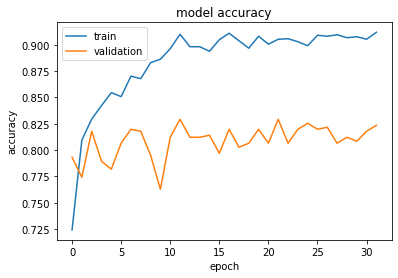

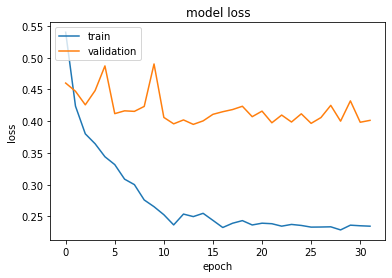

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Test Modelo y Evaluación del desempeño

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = test_datagen.flow_from_directory(
                                                    test_data_dir,  
                                                    target_size=(img_height,img_width), 
                                                    batch_size=batch_size,  
                                                    class_mode='categorical',
                                                    shuffle=False
                                                  )


model.load_weights(checkpoint_filepath)
model.evaluate(test_generator, batch_size=128)

import sklearn
from sklearn.metrics import f1_score
y_pred = model.predict(X_test)
y_pred = np.fix(y_pred+0.5)
print('F1 score = ',f1_score(y_test, y_pred, average='weighted'))

def get_confusion_matrix(y_true, y_pred, normalized):
    y_pred = np.where(y_pred)
    label_test = y_pred[1]
    y_test = np.where(y_true)
    index = y_test[1]
    n_classes = len(np.unique(y_true))
    M = np.zeros((n_classes, n_classes))
    cont = 0
    for n in range(0,len(index)):
        M[label_test[n]][index[n]] = M[label_test[n]][index[n]]+1
        cont = cont+1
    M.astype('int')
    if normalized == True:
        conf = np.transpose( np.transpose(M)/np.sum(M,axis=1) )
    return conf

conf = get_confusion_matrix(y_test, y_pred, True)
print('Confusion matrix = ')
print(conf)

P = conf.sum(axis=0)
R =  conf.sum(axis=1)
D = R+P
F1i = 2*np.diag(conf)/D
print('F1i Score = ')
print(F1i)

Found 660 images belonging to 2 classes.
11/11 [==============================] - 2s 178ms/step - loss: 0.3828 - accuracy: 0.8227


ValueError: ignored

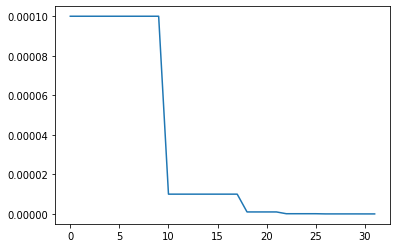

In [ ]:
plt.plot(history.history['lr'])